# Lap Efficiency Correlation Analysis

This notebook will compare multiple variables with lap efficiency to find possible covariates that will help us optimze for lap efficiency.

### Imports

In [1]:
from data_tools import TimeSeries, DBClient, FSGPDayLaps
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
import datetime

from numba.cpython.randomimpl import seed_impl
from numpy import ndarray

FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


In [16]:
def lap_current_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_current_dir = TimeSeries.align(raw_motor_current, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_current.units = "A"
    motor_current.meta["field"] = "Motor Current (adjusted for regen)"
    return motor_current

In [17]:
def lap_power_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    motor_current = lap_current_ts(start_time, end_time, client)
    
    # Align x-axes
    motor_voltage, motor_current = TimeSeries.align(motor_voltage, motor_current)
  
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

In [18]:
def lap_energy_ts(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = lap_power_ts(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

In [19]:
def lap_speed_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    lap_speed: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity")

    lap_speed.units = "m/s"
    lap_speed.meta["field"] = "Speed"
    return lap_speed

In [20]:
def lap_accel_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    accelerator_position: TimeSeries = client.query_time_series(start_time, end_time, "AcceleratorPosition")

    accelerator_position.units = "%"
    accelerator_position.meta["field"] = "Accelerator Position"
    return accelerator_position

In [2]:

# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())
num_laps = len(day_1_idx) + len(day_3_idx)

def collect_lap_data(query_func: Callable) -> ndarray:
    """
    Higher order function - computes `query_func` for all laps and returns the resulting array.

    :param query_func: must take in parameters (lap_start: datetime, lap_end:datetime, data_client:DBClient)
    :return: array of query_func results for all laps
    """
    lap_data = []
    # Iterate through all selected laps
    for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
        for lap_idx in lap_indices:
            lap_num = lap_idx + 1
            lap_start = day_laps.get_start_utc(lap_num)
            lap_end = day_laps.get_finish_utc(lap_num)
            lap_data.append(query_func(lap_start, lap_end, data_client))
            print(f"Processed data for day {day_laps.day} lap {lap_num}")
            print(f"{lap_start=}\n{lap_end=}")
            print(f"{query_func.__name__} result for lap {lap_num}: {lap_data[-1]}\n")
    return np.array(lap_data)

In [3]:
# Get lap average speed and driver data
lap_speeds = []
lap_drivers = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num) 
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))

lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

## Context

The plots below show the speeds that we drove at for each lap in FSGP 2024, excluding day 2. We began quickly, aiming to qualify in one day because of concerns of poor weather on day 2. After running out of battery on day 1, we were made aware of the possibility of a provisional qualification which led us to adapt our strategy to instead demonstrate endurance. We drove three slow laps (just enough to qualify Bryan) in heavy rain on day 2 and spent the rest of the day charging as much as possible for day 3. On day 3, we aimed to spend as long as possible on the track, and succeeded in racing all day long. To maintain SoC, we had to dramatically reduce our speed near the end of the day as can be seen with Phoebe's slow laps.

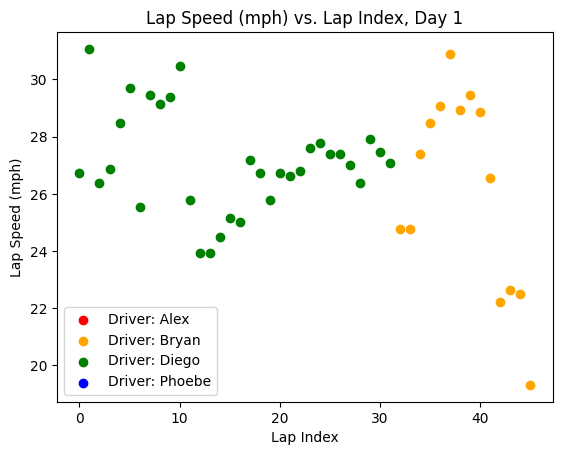

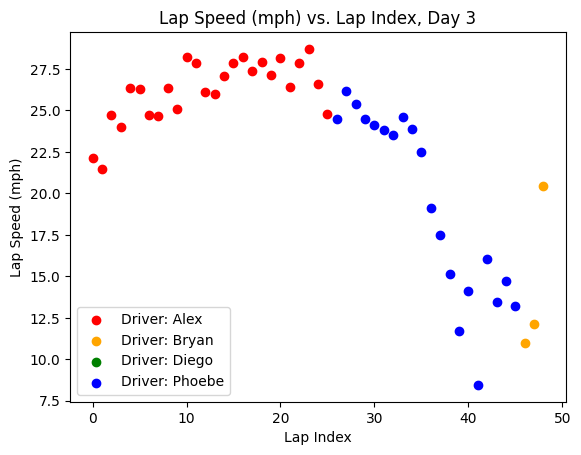

In [12]:
day_1_laps = laps1.get_lap_count() 
day_1_speeds = lap_speeds[:day_1_laps]
day_1_lap_drivers = lap_drivers[:day_1_laps]
for driver, colour in driver_colours.items():
    plt.scatter(np.array(day_1_idx)[day_1_lap_drivers == driver],
                day_1_speeds[day_1_lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Index")
plt.ylabel("Lap Speed (mph)")
plt.legend(loc="lower left")
plt.title(f"Lap Speed (mph) vs. Lap Index, Day 1")
plt.show()

day_3_speeds = lap_speeds[day_1_laps:]
day_3_lap_drivers = lap_drivers[day_1_laps:]
for driver, colour in driver_colours.items():
    plt.scatter(np.array(day_3_idx)[day_3_lap_drivers == driver],
                day_3_speeds[day_3_lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Index")
plt.ylabel("Lap Speed (mph)")
plt.legend(loc="lower left")
plt.title(f"Lap Speed (mph) vs. Lap Index, Day 3")
plt.show()

## Data Filters

We can calculate the total distance traveled as the integral of speed and use this to eliminate extreme values - that is, laps where we did not travel the whole track or went extra far.

In [23]:
def get_lap_distance(start, end, client):
    speed_array: TimeSeries = lap_speed_ts(start, end, client)  # in meters per second
    return np.sum(speed_array) * speed_array.granularity  # in meters
lap_distances_m = collect_lap_data(get_lap_distance)

distance_filter = np.logical_and(lap_distances_m > 5000, lap_distances_m < 5200)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 1: 5425.417711959088

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 2: 5121.933540992318

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 3: 5098.6438243688335

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 4: 5182.615597100614

Processed data

## Lap Efficiency and Average Speed (mph)

Below are plots of `lap efficiency` and `average speed` in miles per hour

In [21]:
def lap_total_energy(start, end, client):
    return lap_energy_ts(start, end, client)[-1]
lap_energies = collect_lap_data(lap_total_energy)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_total_energy result for lap 1: 846444.9773751661

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_total_energy result for lap 2: 745938.756712621

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_total_energy result for lap 3: 624473.3340006383

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
lap_total_energy result for lap 4: 629948.0841042214

Processed data f

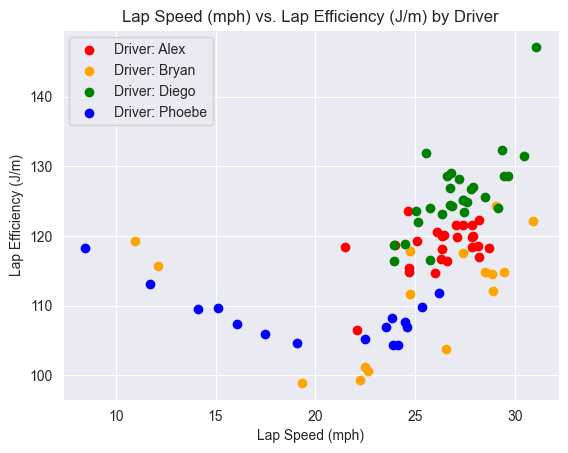

np.mean(lap_energies)=np.float64(594633.7845049766)


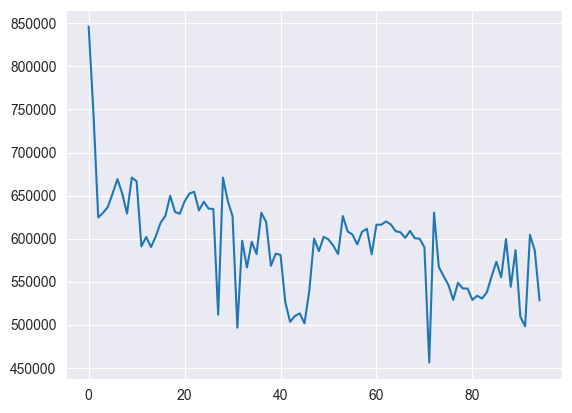

In [16]:
lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_speeds[combined_filter],
                lap_efficiencies[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Driver")
plt.show()

In [12]:
def get_speed_variance(start, end, client):
    return np.var(lap_speed_ts(start, end, client).base)
lap_speed_variances = collect_lap_data(get_speed_variance)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_speed_variance result for lap 1: 10.87254858065726

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_speed_variance result for lap 2: 2.7063311230326206

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_speed_variance result for lap 3: 1.1810729711406096

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_speed_variance result for lap 4: 1.8953857772669802

Proc

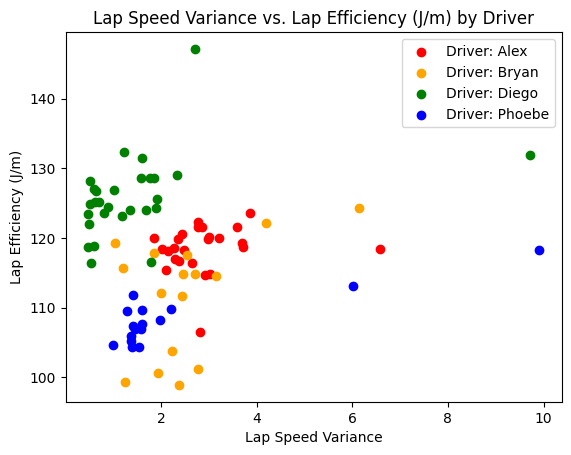

In [85]:
# -------- PLOT SPEED VARIANCE VS EFFICIENCY --------
for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_speed_variances[combined_filter],
                lap_efficiencies[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed Variance")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed Variance vs. Lap Efficiency (J/m) by Driver")
plt.show()

In [86]:
def get_power_variance(start, end, client):
    return np.var(lap_power_ts(start, end, client).base)
lap_power_variances = collect_lap_data(get_power_variance)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_power_variance result for lap 1: 4302888.456773275

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_power_variance result for lap 2: 4820642.955524361

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_power_variance result for lap 3: 1816428.9911575695

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_power_variance result for lap 4: 2094649.1304004432

Proce

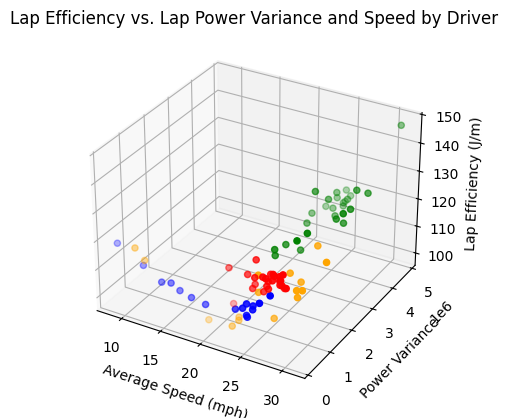

In [92]:
# -------- PLOT SPEED, POWER VARIANCE AND EFFICIENCY --------
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    ax.scatter(lap_speeds[combined_filter],
               lap_power_variances[combined_filter],
               lap_efficiencies[combined_filter],
               c=colour,
               label=f"Driver: {driver}")
ax.set_xlabel('Average Speed (mph)')
ax.set_ylabel('Power Variance')
ax.set_zlabel('Lap Efficiency (J/m)')
plt.title(f"Lap Efficiency vs. Lap Power Variance and Speed by Driver")
plt.show()

In [88]:
def get_accelerator_variance(start, end, client):
    return np.var(lap_accel_ts(start, end, client).base)
lap_accelerator_variances = collect_lap_data(get_accelerator_variance)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_accelerator_variance result for lap 1: 1331.1183650608573

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_accelerator_variance result for lap 2: 1509.3745998505535

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_accelerator_variance result for lap 3: 585.6232103902596

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_accelerator_variance result for lap 4: 

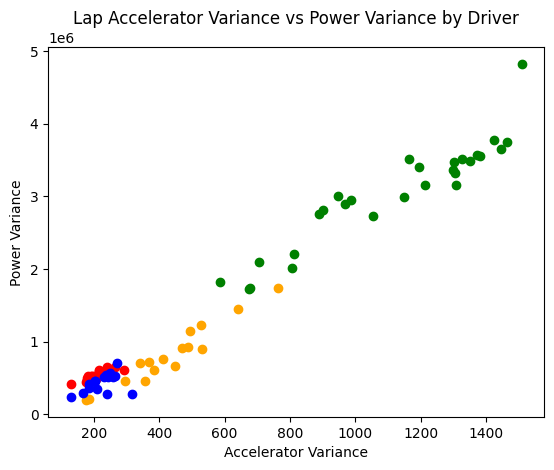

In [93]:
# -------- PLOT ACCELERATOR VARIANCE VS POWER VARIANCE --------
for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_accelerator_variances[combined_filter],
               lap_power_variances[combined_filter],
               c=colour,
               label=f"Driver: {driver}")
plt.xlabel('Accelerator Variance')
plt.ylabel('Power Variance')
plt.title(f"Lap Accelerator Variance vs Power Variance by Driver")
plt.show()

In [91]:
def get_current_variance(start, end, client):
    return np.var(lap_current_ts(start, end, client).base)
lap_current_variances = collect_lap_data(get_current_variance)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_current_variance result for lap 1: 285.34721149613296

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_current_variance result for lap 2: 322.56749447556626

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_current_variance result for lap 3: 120.36607184141536

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_current_variance result for lap 4: 140.30409378390

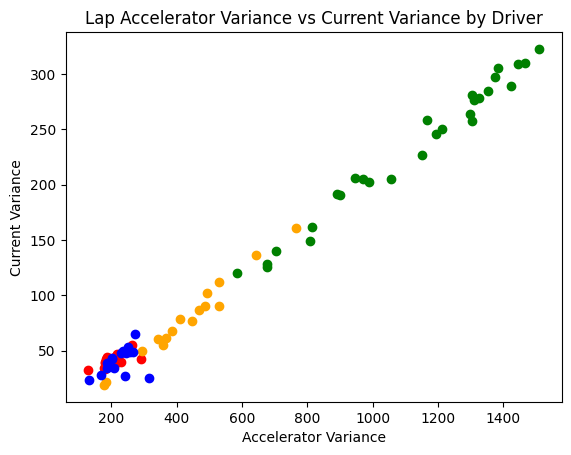

In [94]:
# -------- PLOT ACCELERATOR VARIANCE VS POWER VARIANCE --------
for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_accelerator_variances[combined_filter],
               lap_current_variances[combined_filter],
               c=colour,
               label=f"Driver: {driver}")
plt.xlabel('Accelerator Variance')
plt.ylabel('Current Variance')
plt.title(f"Lap Accelerator Variance vs Current Variance by Driver")
plt.show()

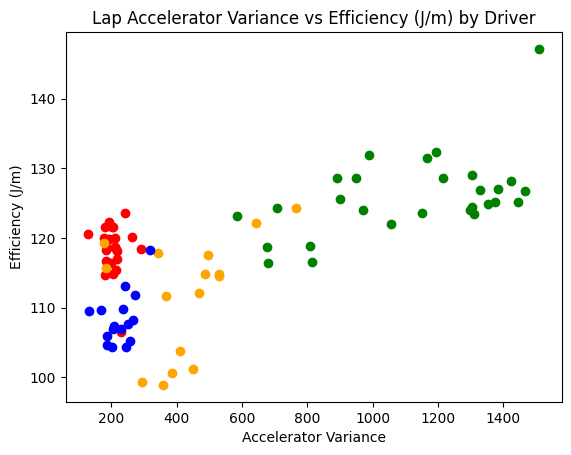

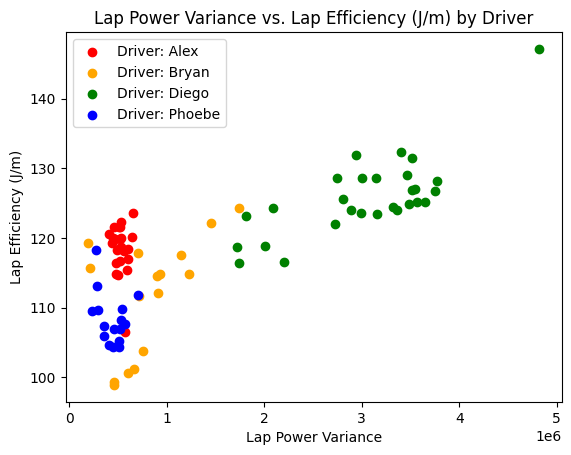

In [95]:
# -------- PLOT ACCELERATOR VARIANCE VS EFFICIENCY --------
for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_accelerator_variances[combined_filter],
               lap_efficiencies[combined_filter],
               c=colour,
               label=f"Driver: {driver}")
plt.xlabel('Accelerator Variance')
plt.ylabel('Efficiency (J/m)')
plt.title(f"Lap Accelerator Variance vs Efficiency (J/m) by Driver")
plt.show()

# -------- PLOT POWER VARIANCE VS EFFICIENCY --------

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_power_variances[combined_filter],
                lap_efficiencies[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Power Variance")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Power Variance vs. Lap Efficiency (J/m) by Driver")
plt.show()

In [ ]:
def get_accel_variance(start, end, client):
    return np.var(np.diff(lap_speed_ts(start, end, client)))
lap_accel_variance = collect_lap_data(get_accel_variance)

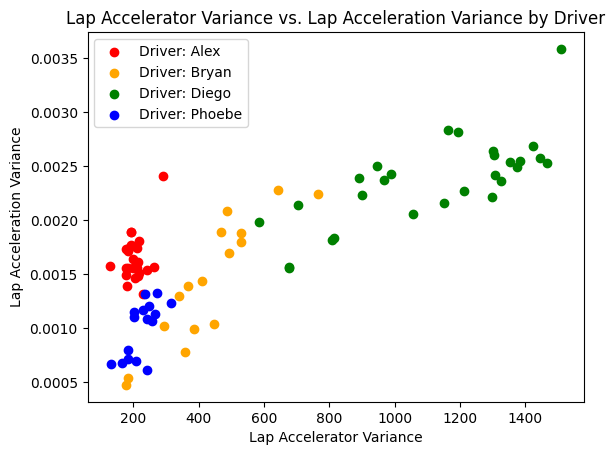

In [98]:
# -------- PLOT POWER VARIANCE VS EFFICIENCY --------

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_accelerator_variances[combined_filter],
                lap_accel_variance[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Accelerator Variance")
plt.ylabel("Lap Acceleration Variance")
plt.legend()
plt.title(f"Lap Accelerator Variance vs. Lap Acceleration Variance by Driver")
plt.show()

In [12]:
def get_rms_accel(start, end, client):
    return np.sqrt(np.mean(np.square(np.diff(lap_speed_ts(start, end, client)))))
rms_accel = collect_lap_data(get_rms_accel)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_rms_accel result for lap 1: 0.06132426910125193

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_rms_accel result for lap 2: 0.059867393434806904

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_rms_accel result for lap 3: 0.04452411103764989

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_rms_accel result for lap 4: 0.04629296199659461

Processed data for

In [13]:
def get_stdev(start, end, client):
    return np.std(np.diff(lap_speed_ts(start, end, client)))
stdev = collect_lap_data(get_stdev)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_stdev result for lap 1: 0.061290037569752105

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_stdev result for lap 2: 0.059867389765894986

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_stdev result for lap 3: 0.04452390802267423

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_stdev result for lap 4: 0.04629287988247278

Processed data for day 1 lap 5
la

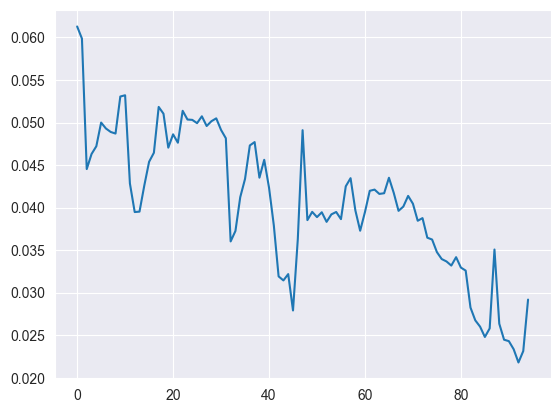

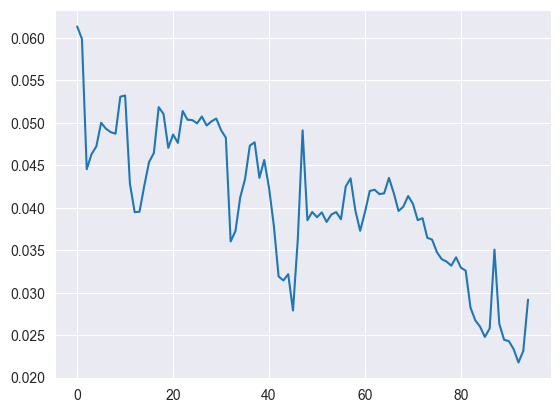

In [15]:
plt.plot(stdev)
plt.show()
plt.plot(rms_accel)
plt.show()

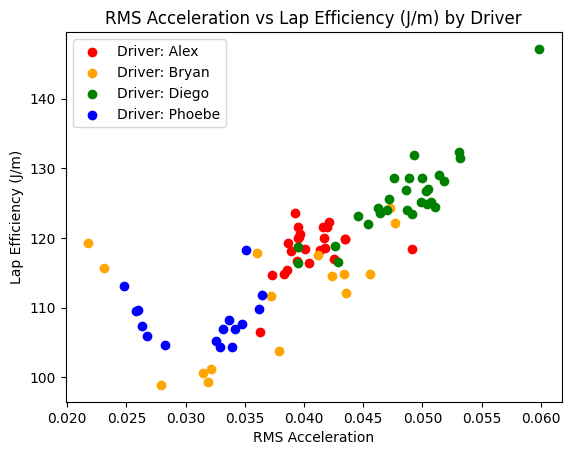

In [99]:

# -------- PLOT POWER VARIANCE VS EFFICIENCY --------

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(rms_accel[combined_filter],
                lap_efficiencies[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("RMS Acceleration")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"RMS Acceleration vs Lap Efficiency (J/m) by Driver")
plt.show()

In [1]:
for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(rms_accel[combined_filter],
                lap_speeds[combined_filter],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("RMS Acceleration")
plt.ylabel("Lap Speed")
plt.show()

NameError: name 'driver_colours' is not defined

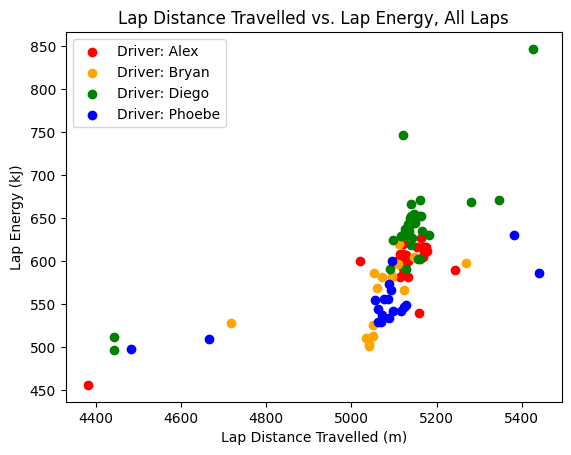

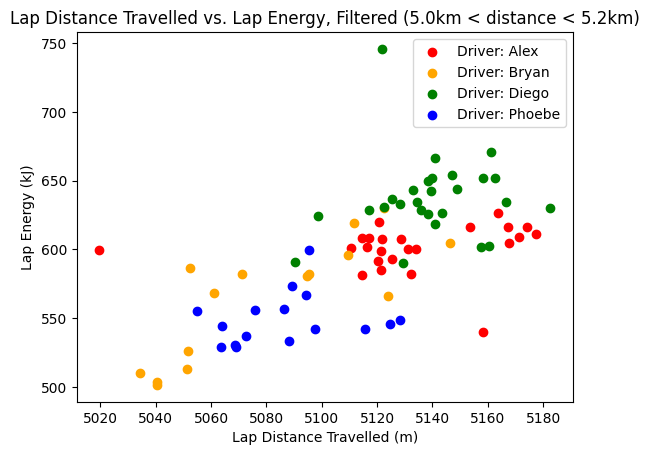

In [27]:
for driver, colour in driver_colours.items():
    plt.scatter(lap_distances_m[lap_drivers == driver],
                lap_energies[lap_drivers == driver] / 1000,
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Distance Travelled (m)")
plt.ylabel("Lap Energy (kJ)")
plt.legend()
plt.title(f"Lap Distance Travelled vs. Lap Energy, All Laps")
plt.show()

for driver, colour in driver_colours.items():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    plt.scatter(lap_distances_m[combined_filter],
                lap_energies[combined_filter] / 1000,
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Distance Travelled (m)")
plt.ylabel("Lap Energy (kJ)")
plt.legend()
plt.title(f"Lap Distance Travelled vs. Lap Energy, Filtered (5.0km < distance < 5.2km)")
plt.show()

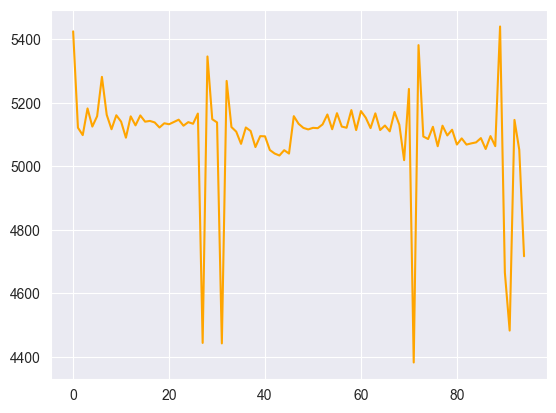

In [28]:
# print(f"Average Lap Energy: {np.mean(lap_energies)}")
# fig, ax1 = plt.subplots()
# ax1.plot(lap_speeds, color="blue")
# ax2 = ax1.twinx()
plt.plot(lap_distances_m, color="orange")
plt.show()